In [60]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd

# load png image as numpy matrix at given user path
def load_image(path):
    from PIL import Image
    img = Image.open(path)
    img.load()
    data = np.asarray(img, dtype="float32")
    return data
    
# smoothstep function
def smoothstep(min, max, x):
    if x < min:
        return 0.0
    if x > max:
        return 1.0
    x = (x - min) / (max - min)
    return x * x * (3 - 2 * x)


def SVD_Decomposition(matrix, num_ranks, N, Nc):
    # normalize the matrix
    matrix = matrix / np.sum(matrix)

    # calculate the SVD decomposition
    U, s, V = svd(matrix)
        
    #also write the glsl code to a file and clear the file first
    with open("D:\Development\ShaderConvolution\kernels.glsl", "w") as f:
        f.write("//The first {} columns of the U matrix: \n".format(num_ranks))
    
        f.write("float U[{}] = float[](".format(N * num_ranks))
        array = ""
        for i in range(num_ranks-1):
            for j in range(N):
                array += "{:.4E}, ".format(U[j, i])
        for j in range(N-1):
            array += "{:.4E}, ".format(U[j, num_ranks-1])
        array += "{:.4E}".format(U[N-1, num_ranks-1])
        f.write(array)
        f.write("); \n")

        f.write("//The first {} rows of the V matrix: \n".format(num_ranks))
        f.write("float V[{}] = float[](".format(N * num_ranks))
        array = ""
        for i in range(num_ranks-1):
            for j in range(N):
                array += "{:.4E}, ".format(V[i, j] * s[i])
        for j in range(N-1):
            array += "{:.4E}, ".format(V[num_ranks-1, j] * s[num_ranks-1])
        array += "{:.4E}".format(V[num_ranks-1, N-1] * s[num_ranks-1])
        f.write(array)
        f.write("); \n")
        f.write("//center of the convolution \n")
        f.write("int Nc = {}; \n".format(Nc))
        f.write("//number of ranks \n")
        f.write("int Nr = {}; \n".format(num_ranks))
        f.write("//convolution size \n")
        f.write("int N = {}; \n".format(N))
    
    # reconstruct the matrix using 2 first ranks
    matrix_reconstructed = np.zeros((N, N))
    for i in range(num_ranks):
        matrix_reconstructed += s[i] * np.outer(U[:, i], V[i, :])

    # plot the original and reconstructed matrices in log scale
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(np.log10(matrix), cmap="gray")
    axs[0].set_title("Original matrix")
    axs[1].imshow(np.log10(matrix_reconstructed), cmap="gray")
    axs[1].set_title("Reconstructed matrix (using {} ranks)".format(num_ranks))
    plt.show()


In [18]:
matrix = load_image("D:/FOIMEjiXMBAGpbT.png")
matrix = matrix[:,:,0]

#make the matrix square
N = max(matrix.shape)
matrix = np.pad(matrix, ((0, N - matrix.shape[0]), (0, N - matrix.shape[1])), 'constant', constant_values=0)

N = matrix.shape[0]
Nc = N//2

# define the N*N matrix with a Gaussian in it
#N = 51
#Nc = 25
#matrix = np.zeros((N, N))
#for i in range(N):
#    for j in range(N):
#        R = np.sqrt((i - Nc) ** 2 + (j - Nc) ** 2)
#        # gaussian line in x direction
#        xspike = 0. * np.exp(-((i - Nc) / 10.0) ** 2)
#        # gaussian line in y direction
#        yspike = 0. * np.exp(-((j - Nc) / 10.0) ** 2)
#        kernel = xspike + yspike + (R**2 + 0.5)**(-1) 
#        matrix[i, j] = (1.0 - smoothstep(N*0.42, N * 0.45, R))
#
## normalize the matrix, so that the sum of all elements is 1
#matrix /= np.sum(matrix)


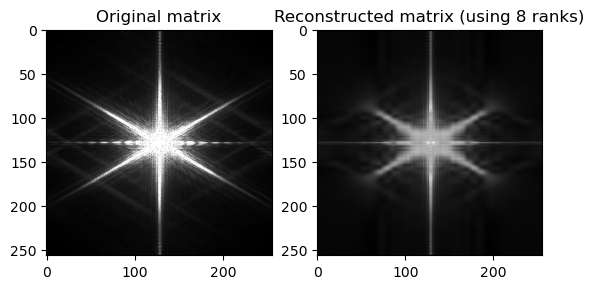

In [21]:
SVD_Decomposition(matrix, 8, N, Nc)

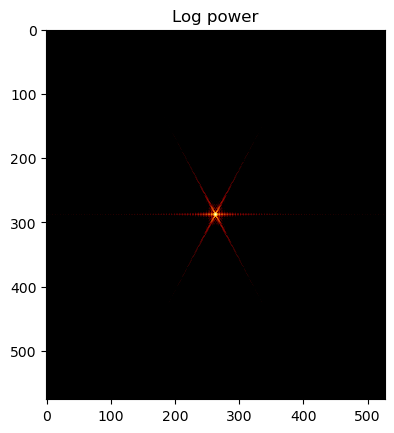

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

img = load_image("D:\Lyame.png") 
img = img[:, :527, :3].sum(axis=2) / 3. > 0.5
ft = np.fft.fftshift(np.fft.fft2(img))

p = np.abs(ft)**2
log_power = np.log10(p/p.max()) # log power

#plot log power
plt.imshow(log_power, cmap="afmhot", vmin=-6)
plt.title("Log power")
plt.show()

(264, 263)


C:\Users\micha\AppData\Local\Temp\ipykernel_14456\411119349.py:72: RuntimeWarning: invalid value encountered in log10
  axs[1].imshow(np.log10(matrix_reconstructed), cmap="gray")


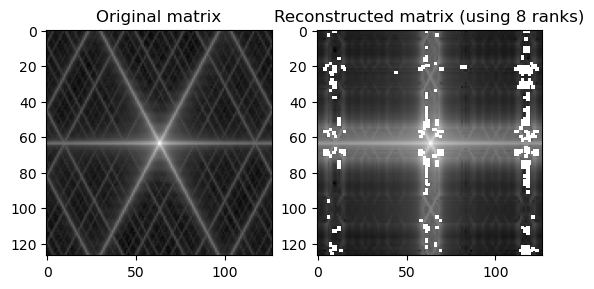

In [77]:
#make it square
size = p.shape
N = min(size)

if size[0] >= size[1]:
    pad = (size[0] - size[1]) // 2
    pow = p[pad:(size[0] - pad - 1), :]
else:
    pad = (size[1] - size[0]) // 2
    pow = p[:, pad:(size[1] - pad - 1)]


M = 127

#resample the N*N spectrum into a M*M matrix
pow = gaussian_filter(pow, 0.75)
#interpolate the spectrum to a M*M matrix
powI = np.zeros((M, M))

def Bilinear(array, x, y):
    x1 = int(x)
    x2 = x1 + 1
    y1 = int(y)
    y2 = y1 + 1
    a = x - x1
    b = y - y1
    return (1 - a) * (1 - b) * array[x1, y1] + a * (1 - b) * array[x2, y1] + (1 - a) * b * array[x1, y2] + a * b * array[x2, y2]

#bi-linear interpolation
for i in range(M):
    for j in range(M):
        powI[i, j] = Bilinear(pow, i * N / M, j * N / M)

#find the center coordinate (with max power)
centerPos = np.unravel_index(np.argmax(pow), pow.shape)

print(centerPos)

#pow = pow**2
SVD_Decomposition(powI, 8, powI.shape[0], powI.shape[0]//2)

In [46]:
p.shape

(576, 527)

In [50]:
pow.shape

(527, 527)

In [ ]:
p.